In [170]:
### Trying to reproduce the results using transformers

import copy
from typing import Optional, Any
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import functional as F
from torch.nn import Module
from torch.nn import MultiheadAttention
from torch.nn import ModuleList
from torch.nn.init import xavier_uniform_
from torch.nn import Dropout
from torch.nn import Linear
from torch.nn import LayerNorm, BatchNorm1d
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
import math

from torch.utils.data import Dataset, DataLoader
from config.config import DEVICE
import time
import os
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [2]:
import pickle
def load_config(data_path, fold="train"):
    with open(data_path.format(fold, "config", "pkl"), "rb") as f:
        config = pickle.load(file=f)
    n_units = config["n_units"]
    n_treated = config["n_treated"]
    n_units_total = config["n_units_total"]
    step = config["step"]
    train_step = config["train_step"]
    control_sample = config["control_sample"]
    noise = config["noise"]
    n_basis = config["n_basis"]
    n_cluster = config["n_cluster"]
    return n_units, n_treated, n_units_total, step, train_step, control_sample, noise, n_basis, n_cluster

def load_tensor(data_path, fold="train"):
    print(data_path.format(fold, "x_full", "pth"))
    x_full = torch.load(data_path.format(fold, "x_full", "pth"))
    t_full = torch.load(data_path.format(fold, "t_full", "pth"))
    mask_full = torch.load(data_path.format(fold, "mask_full", "pth"))
    batch_ind_full = torch.load(data_path.format(fold, "batch_ind_full", "pth"))
    y_full = torch.load(data_path.format(fold, "y_full", "pth"))
    y_control = torch.load(data_path.format(fold, "y_control", "pth"))
    y_mask_full = torch.load(data_path.format(fold, "y_mask_full", "pth"))
    m = torch.load(data_path.format(fold, "m", "pth"))
    sd = torch.load(data_path.format(fold, "sd", "pth"))
    treatment_effect = torch.load(data_path.format(fold, "treatment_effect", "pth"))
    return x_full, t_full, mask_full, batch_ind_full, y_full, y_control, y_mask_full, m, sd, treatment_effect


In [3]:
data_path = "./data/sync6d-p10-seed-100"+ "/{}-{}.{}"
n_units, n_treated, n_units_total, step, train_step, control_sample, noise, n_basis, n_cluster = load_config(
    data_path, "train"
)

In [4]:
print(n_units, n_treated, n_units_total, step, train_step, control_sample, noise, n_basis, n_cluster)

1000 200 1200 30 25 1000 0.1 6 2


In [5]:
(x_full,t_full,mask_full,batch_ind_full,y_full,y_control,y_mask_full,m,sd,treatment_effect,) = load_tensor(data_path, "train")

./data/sync6d-p10-seed-100/train-x_full.pth


In [6]:
print(f'x_full: {x_full.shape}') ### Temporal Covariates
print(f't_full: {t_full.shape}') ###  Time -25 to 4
print(f'mask_full: {mask_full.shape}') ### Masking vector
print(f'batch_ind_full: {batch_ind_full.shape}') ### Batch indexes
print(f'y_full: {y_full.shape}')   ### y_i ### need to predict this
print(f'y_control: {y_control.shape}') #### y_i(0)
print(f'treatment_effect: {treatment_effect.shape}')  #### y_i(1)
print(f'y_mask_full: {y_mask_full.shape}') ### To separate control and treatment groups  
print(f'm: {m.shape} {m}') 
print(f'sd: {sd.shape} {sd}')


x_full: torch.Size([25, 1200, 3])
t_full: torch.Size([25, 1200, 3])
mask_full: torch.Size([25, 1200, 3])
batch_ind_full: torch.Size([1200])
y_full: torch.Size([5, 1200, 1])
y_control: torch.Size([5, 1000, 1])
treatment_effect: torch.Size([5, 200, 1])
y_mask_full: torch.Size([1200])
m: torch.Size([3]) tensor([0.0118, 0.1373, 1.0291], device='cuda:3')
sd: torch.Size([3]) tensor([0.7947, 3.5020, 7.6243], device='cuda:3')


In [7]:
class LDL_Stim_Dataset(Dataset):
    def __init__(self, data_path, fold,device):
        # Get the data
        (self.x_full,self.t_full,self.mask_full,self.batch_ind_full,
         self.y_full,self.y_control,self.y_mask_full,
         self.m,self.sd,self.treatment_effect,) = load_tensor(data_path, fold)
        print(self.m,self.sd)
        # print(self.x_full.max(),self.x_full.min(),self.x_full.mean())
        self.x_full = torch.moveaxis(self.x_full,1,0)
        # self.x_full = torch.moveaxis(self.x_full,1,-1)
        self.t_full = torch.moveaxis(self.t_full,1,0)
        # self.t_full = torch.moveaxis(self.t_full,1,-1)
        self.mask_full = torch.moveaxis(self.mask_full,1,0)
        # self.mask_full = torch.moveaxis(self.mask_full,1,-1)
        self.y_full = torch.moveaxis(self.y_full,1,0).squeeze()
        self.y_control = torch.moveaxis(self.y_control,1,0)
        self.treatment_effect = torch.moveaxis(self.treatment_effect,1,0)
        # print(self.batch_ind_full)
        self.device = device
        # for i in range (self.x_full.shape[-1]):
        #     self.x_full[:,:,i] = (self.x_full[:,:,i] - self.m[i])/self.sd[i]
        # print(self.x_full.max(),self.x_full.min(),self.x_full.mean())
        print(f'x_full: {self.x_full.shape}') ### Temporal Covariates
        print(f't_full: {self.t_full.shape}') ###  Time -25 to 4
        print(f'mask_full: {self.mask_full.shape}') ### Masking vector
        print(f'batch_ind_full: {self.batch_ind_full.shape}') ### Batch indexes
        print(f'y_full: {self.y_full.shape}')   ### y_i ### need to predict this
        print(f'y_control: {self.y_control.shape}') #### y_i(0)
        print(f'treatment_effect: {self.treatment_effect.shape}')  #### y_i(1)
        print(f'y_mask_full: {self.y_mask_full.shape}') ### if outcome not available during 
        print(f'm: {self.m.shape}') 
        print(f'sd: {self.sd.shape}')

        
    def __len__(self):
        return len(self.x_full)

    def __getitem__(self, idx):
        x = self.x_full[idx].to(self.device)    
        t = self.t_full[idx].to(self.device)    
        m = self.mask_full[idx].to(self.device)    
        y = self.y_full[idx].to(self.device)    
        y_mask = self.y_mask_full[idx].unsqueeze(-1).to(self.device)    
        return x,t,m,y,y_mask

In [8]:
data_path = "./data/sync6d-p10-seed-100"+ "/{}-{}.{}"
train_dataset = LDL_Stim_Dataset(data_path, fold = 'train',device = DEVICE)
val_dataset = LDL_Stim_Dataset(data_path, fold = 'val',device = DEVICE)

./data/sync6d-p10-seed-100/train-x_full.pth
tensor([0.0118, 0.1373, 1.0291], device='cuda:3') tensor([0.7947, 3.5020, 7.6243], device='cuda:3')
x_full: torch.Size([1200, 25, 3])
t_full: torch.Size([1200, 25, 3])
mask_full: torch.Size([1200, 25, 3])
batch_ind_full: torch.Size([1200])
y_full: torch.Size([1200, 5])
y_control: torch.Size([1000, 5, 1])
treatment_effect: torch.Size([200, 5, 1])
y_mask_full: torch.Size([1200])
m: torch.Size([3])
sd: torch.Size([3])
./data/sync6d-p10-seed-100/val-x_full.pth
tensor([0.0024, 0.0946, 0.9151], device='cuda:3') tensor([0.7631, 3.3575, 7.2832], device='cuda:3')
x_full: torch.Size([1200, 25, 3])
t_full: torch.Size([1200, 25, 3])
mask_full: torch.Size([1200, 25, 3])
batch_ind_full: torch.Size([1200])
y_full: torch.Size([1200, 5])
y_control: torch.Size([1000, 5, 1])
treatment_effect: torch.Size([200, 5, 1])
y_mask_full: torch.Size([1200])
m: torch.Size([3])
sd: torch.Size([3])


In [9]:
train_data_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_data_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

In [10]:
x,t,m,y,y_mask   = next(iter(train_data_loader))
print(x.shape,t.shape,m.shape,y.shape,y_mask.shape )

torch.Size([32, 25, 3]) torch.Size([32, 25, 3]) torch.Size([32, 25, 3]) torch.Size([32, 5]) torch.Size([32, 1])


## Model

In [11]:
def _get_clones(module, N):
    return ModuleList([copy.deepcopy(module) for i in range(N)])


def _get_activation_fn(activation):
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu

    raise RuntimeError("activation should be relu/gelu, not {}".format(activation))
    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [12]:
class get_Embedding(nn.Module): 
    def __init__(self, in_channels: int = 3, emb_size: int = 64):
        super(get_Embedding, self).__init__()

        self.projection =  nn.Sequential(
            Rearrange('b s e -> b e s'),
            nn.Conv1d(in_channels, emb_size, kernel_size = 1, stride = 1),
            # Rearrange('b e s -> b s e')
            )
            
        self.arrange1 = Rearrange('b e s -> s b e')
        self.pos = PositionalEncoding(d_model=emb_size)
        self.arrange2 = Rearrange('s b e -> b s e  ')

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)  
        # add position embedding
        x = self.arrange1(x)
        x = self.pos(x)
        x = self.arrange2(x)
        return x

In [13]:
class Atten_block(nn.Module): 
    def __init__(self, d_model=64, nhead=8, dropout=0.1,dim_feedforward=512,
                 layer_norm_eps=1e-5):
        super(Atten_block, self).__init__()
       
        self.norm = LayerNorm(d_model, eps=layer_norm_eps)#, **factory_kwargs)  
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)#,
                                            # **factory_kwargs)
        self.dropout = Dropout(dropout)
        
        
        self.norm_ff = LayerNorm(d_model, eps=layer_norm_eps)#, **factory_kwargs)
        self.linear1 = Linear(d_model, dim_feedforward)#, **factory_kwargs)
        self.relu = nn.ReLU()
        self.dropout1 = Dropout(dropout)
        self.linear2 = Linear(dim_feedforward, d_model)#, **factory_kwargs)
        self.dropout2 = Dropout(dropout)
 

    def forward(self, x: Tensor) -> Tensor:
        src = x
        src2 = self.self_attn(src, src, src)[0]
        out = src + self.dropout(src2)
        out = self.norm(out)   ########
        
        src2 = self.linear2(self.dropout1(self.relu(self.linear1(out))))
        out = out + self.dropout2(src2)
        out = self.norm_ff(out)
        return out                           

In [14]:
class Trans_Encoder(nn.Module): 
    def __init__(self, in_channels = 3,d_model=64, nhead=8, dropout=0.1,dim_feedforward=512,
                 layer_norm_eps=1e-5):
        super(Trans_Encoder, self).__init__()
        
        self.embed = get_Embedding(in_channels = in_channels, emb_size = d_model)
        self.atten_1 =  Atten_block(d_model=d_model, nhead=nhead, dropout=dropout,
                                    dim_feedforward=dim_feedforward,layer_norm_eps=layer_norm_eps)
        self.atten_2 =  Atten_block(d_model=d_model, nhead=nhead, dropout=dropout,
                                    dim_feedforward=dim_feedforward,layer_norm_eps=layer_norm_eps)
        
    def forward(self, x):
        x = self.embed(x)
        x = self.atten_1(x)
        x = self.atten_2(x)
        
        return x
    

class Trans_Decoder(nn.Module): 
    def __init__(self,out_channels= 3, d_model=64, nhead=8, dropout=0.1,dim_feedforward=512,
                 layer_norm_eps=1e-5):
        super(Trans_Decoder, self).__init__()
        
        # self.embed = get_Embedding(in_channels = 3, emb_size = d_model)
        self.atten_1 =  Atten_block(d_model=d_model, nhead=nhead, dropout=dropout,
                                    dim_feedforward=dim_feedforward,layer_norm_eps=layer_norm_eps)
        self.atten_2 =  Atten_block(d_model=d_model, nhead=nhead, dropout=dropout,
                                    dim_feedforward=dim_feedforward,layer_norm_eps=layer_norm_eps)
        self.final = Linear(d_model, out_channels)
        # self.arrange1 = Rearrange('b e s -> s b e')
    def forward(self, c):
        # x = self.embed(x)
        x = self.atten_1(c)
        x = self.atten_2(x)
        x = self.final(x)
        
        
        return x

class linear_cls(nn.Module):
    def __init__(self,y_times = 5):
        super(linear_cls, self).__init__()
        
        self.Q = nn.Linear(1600, y_times)
    def forward(self, c):
        x = torch.flatten(c, start_dim=1, end_dim=- 1) 
        x = self.Q(x)
        return x
        

In [15]:
encoder = Trans_Encoder().to(DEVICE)
decoder = Trans_Decoder().to(DEVICE)
Q = linear_cls().to(DEVICE)

## Testing
x,t,m,y,y_mask   = next(iter(train_data_loader))
print(x.shape,t.shape,m.shape,y.shape,y_mask.shape )

c_hat = encoder(x)
x_hat = decoder(c_hat)
y_hat = Q(c_hat)

print(c_hat.shape,x_hat.shape,y_hat.shape)

torch.Size([32, 25, 3]) torch.Size([32, 25, 3]) torch.Size([32, 25, 3]) torch.Size([32, 5]) torch.Size([32, 1])
torch.Size([32, 25, 64]) torch.Size([32, 25, 3]) torch.Size([32, 5])


## Representation learning training

In [25]:
#Training parameters
criterion = nn.L1Loss()
lr_u  = 0.001   
beta_1 = 0.9
beta_2 = 0.999
n_epochs = 1000
save_model_freq = 100

In [26]:
#Initiate optimizers
opt =  torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters())+ list(Q.parameters()), lr=lr_u, betas=(beta_1, beta_2))

In [27]:
def recon_loss(x_hat,x,m):
    criterion = nn.MSELoss()
    return criterion(x_hat*m,x*m)

def sup_loss(y_hat,y,y_mask):
    criterion = nn.MSELoss()
    return criterion(y_hat*y_mask,y*y_mask)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count != 0 else 0


In [12]:
is_wandb = False
if is_wandb:
    import wandb
    wandb.init(project="SyncTwin", entity="jathurshan_0330")
    wandb.run.name = "Initial_With_Transformers"
    wandb.run.save()
    
    exp_path = f"/home/jupyter-jathurshan/SyncTwin_Results/{wandb.run.name}"
    if not os.path.exists(exp_path):
        os.mkdir(exp_path)


In [29]:
def train(encoder,decoder,Q,opt,data_loader,is_wandb,verbose_freq = 500):
    encoder.train()
    decoder.train()
    Q.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    train_losses = AverageMeter()
    end = time.time()
    
    for batch_idx, (x,t,m,y,y_mask ) in enumerate(data_loader): 
        data_time.update(time.time() - end)
        
        opt.zero_grad()
        c_hat = encoder(x)
        x_hat = decoder(c_hat)
        y_hat = Q(c_hat)
        
        loss = recon_loss(x_hat,x,m) + sup_loss(y_hat,y,y_mask)
        
        loss.backward()
        opt.step()
        
        train_losses.update(loss.data.item())
        batch_time.update(time.time() - end)
        end = time.time()
        
        if (batch_idx+1) % verbose_freq == 0:
            msg = 'Epoch: [{0}/{3}][{1}/{2}]\t' \
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t' \
                  'Speed {speed:.1f} samples/s\t' \
                  'Data {data_time.val:.3f}s ({data_time.avg:.3f}s)\t' \
                  'Loss {train_loss.val:.5f} ({train_loss.avg:.5f})\t'.format(
                      epoch_idx+1, batch_idx,len(data_loader), n_epochs , batch_time=batch_time,
                      speed=x.size(0)/batch_time.val,
                      data_time=data_time, train_loss=train_losses)
            print(msg)
        
        if is_wandb:
            wandb.log({"batch_loss": loss.data.item()})
    
    
    if is_wandb:
            wandb.log({"train_epoch_loss": train_losses.avg})
            wandb.log({"training time/Iter": batch_time.sum/len(data_loader)})
    
    
    # print(f"Evaluation   Epoch : {epoch_idx+1}  =====================>")
    print(f"Training Epoch Loss: {train_losses.avg}")#,Training Time/Epoch: {batch_time.sum},Training Time/Iter: {batch_time.sum/len(data_loader)}")
    
    
        
        
        
    

In [30]:
def validate(encoder,decoder,Q,data_loader,is_wandb):
    encoder.eval()
    decoder.eval()
    Q.eval()
    
    val_losses = AverageMeter()
    
    
    with torch.no_grad():
        for batch_idx, (x,t,m,y,y_mask) in enumerate(data_loader): 
            c_hat = encoder(x)
            x_hat = decoder(c_hat)
            y_hat = Q(c_hat)

            loss = recon_loss(x_hat,x,m) + sup_loss(y_hat,y,y_mask)
            
            val_losses.update(loss.data.item())
    
    if is_wandb:
            wandb.log({"val_epoch_loss": val_losses.avg})
    
    
    # print(f"Evaluation   Epoch : {epoch_idx+1}  =====================>")
    print(f"Val Epoch Loss: {val_losses.avg}")
    return val_losses.avg
        

In [32]:
val_best_loss = 10000000

for epoch_idx in range(n_epochs):
    print(f"Training Epoch : [{epoch_idx+1}/{n_epochs}]===============================================================================")
    
    train(encoder,decoder,Q,opt,train_data_loader,is_wandb,verbose_freq = 500)    
    val_losses = validate(encoder,decoder,Q,val_data_loader,is_wandb) 
    
    if (val_losses < val_best_loss) and is_wandb: 
        val_best_loss = val_losses
        print("Saving Best Model =======================================>")
        torch.save(encoder, f'{exp_path}/encoder.pth.tar')
        torch.save(decoder, f'{exp_path}/decoder.pth.tar')
        torch.save(Q, f'{exp_path}/Q.pth.tar')
        wandb.log({"epoch_saved_Best_Model": epoch_idx+1})


# Inference for predicting conterfactual of y(0)

In [15]:
class LDL_Stim_Inference_Dataset(Dataset):
    def __init__(self, data_path, fold,device,group = 'Treated'):
        # Get the data
        (self.x_full,self.t_full,self.mask_full,self.batch_ind_full,
         self.y_full,self.y_control,self.y_mask_full,
         self.m,self.sd,self.treatment_effect,) = load_tensor(data_path, fold)
        
        
        self.x_full = torch.moveaxis(self.x_full,1,0)
        self.t_full = torch.moveaxis(self.t_full,1,0)
        self.mask_full = torch.moveaxis(self.mask_full,1,0)
        self.y_full = torch.moveaxis(self.y_full,1,0).squeeze()
        self.y_control = torch.moveaxis(self.y_control,1,0)
        self.treatment_effect = torch.moveaxis(self.treatment_effect,1,0)
        
        self.device = device
        
        print(f"Loading {group} Group")
        if group == 'Treated':
            self.x_full = self.x_full[self.y_mask_full==0]
            self.t_full = self.t_full[self.y_mask_full==0]
            self.mask_full = self.mask_full[self.y_mask_full==0]
            self.y_full = self.y_full[self.y_mask_full==0]
            self.batch_ind_full = self.batch_ind_full[self.y_mask_full==0]
        elif group == 'Control':
            self.x_full = self.x_full[self.y_mask_full==1]
            self.t_full = self.t_full[self.y_mask_full==1]
            self.mask_full = self.mask_full[self.y_mask_full==1]
            self.y_full = self.y_full[self.y_mask_full==1]
            self.batch_ind_full = self.batch_ind_full[self.y_mask_full==1]
            
            
        
        
        
        print(f'x_full: {self.x_full.shape}') ### Temporal Covariates
        print(f't_full: {self.t_full.shape}') ###  Time -25 to 4
        print(f'mask_full: {self.mask_full.shape}') ### Masking vector
        print(f'batch_ind_full: {self.batch_ind_full.shape}') ### Batch indexes
        print(f'y_full: {self.y_full.shape}')   ### y_i ### need to predict this
        print(f'y_control: {self.y_control.shape}') #### y_i(0)
        print(f'treatment_effect: {self.treatment_effect.shape}')  #### y_i(1)
        print(f'y_mask_full: {self.y_mask_full.shape}') ### if outcome not available during 
        print(f'm: {self.m.shape}') 
        print(f'sd: {self.sd.shape}')

        
    def __len__(self):
        return len(self.x_full)

    def __getitem__(self, idx):
        x = self.x_full[idx].to(self.device)    
        t = self.t_full[idx].to(self.device)    
        m = self.mask_full[idx].to(self.device)    
        y = self.y_full[idx].to(self.device)    
        y_mask = self.y_mask_full[idx].unsqueeze(-1).to(self.device)  
        batch_ind = self.batch_ind_full[idx].to(self.device)  
        return x,t,m,y,y_mask,batch_ind

In [33]:
test_treated_dataset = LDL_Stim_Inference_Dataset(data_path, fold = 'test',device = DEVICE,group = 'Treated') 
test_control_dataset = LDL_Stim_Inference_Dataset(data_path, fold = 'test',device = DEVICE,group = 'Control') 

./data/sync6d-p10-seed-100/test-x_full.pth
Loading Treated Group
x_full: torch.Size([200, 25, 3])
t_full: torch.Size([200, 25, 3])
mask_full: torch.Size([200, 25, 3])
batch_ind_full: torch.Size([200])
y_full: torch.Size([200, 5])
y_control: torch.Size([1000, 5, 1])
treatment_effect: torch.Size([200, 5, 1])
y_mask_full: torch.Size([1200])
m: torch.Size([3])
sd: torch.Size([3])
./data/sync6d-p10-seed-100/test-x_full.pth
Loading Control Group
x_full: torch.Size([1000, 25, 3])
t_full: torch.Size([1000, 25, 3])
mask_full: torch.Size([1000, 25, 3])
batch_ind_full: torch.Size([1000])
y_full: torch.Size([1000, 5])
y_control: torch.Size([1000, 5, 1])
treatment_effect: torch.Size([200, 5, 1])
y_mask_full: torch.Size([1200])
m: torch.Size([3])
sd: torch.Size([3])


In [38]:
treatment_data_loader = DataLoader(test_treated_dataset, batch_size = 200, shuffle = False)
control_data_loader = DataLoader(test_control_dataset, batch_size = 1000, shuffle = False)

In [39]:
x,t,m,y,y_mask,batch_ind   = next(iter(control_data_loader))
print(x.shape,t.shape,m.shape,y.shape,y_mask.shape,batch_ind.shape,len(control_data_loader),len(treatment_data_loader) )

torch.Size([1000, 25, 3]) torch.Size([1000, 25, 3]) torch.Size([1000, 25, 3]) torch.Size([1000, 5]) torch.Size([1000, 1]) torch.Size([1000]) 1 1


In [40]:
# batch_ind[1]#.detach().cpu().numpy()
# x[batch_ind[1]]

In [41]:
def get_representation(encoder,data_loader):
    
    for batch_idx, (x,t,m,y,y_mask,batch_ind) in enumerate(data_loader): 
        c_hat = encoder(x)
        if batch_idx ==0:
            c = c_hat
        else:
            c = torch.cat((c,c_hat),dim = 0)
    return c
            
    

In [42]:
#Load encoder
enc_path = '/home/jupyter-jathurshan/SyncTwin_Results/Initial_With_Transformers/encoder.pth.tar'
encoder = torch.load(enc_path).to(DEVICE)
encoder.eval()
print(sum([np.prod(p.size()) for p in encoder.parameters()]))

166272


In [166]:
c_treat  = get_representation(encoder,treatment_data_loader).detach().to(DEVICE)
c_control  = get_representation(encoder,control_data_loader).detach().to(DEVICE)

print(c_treat.shape,c_control.shape)

torch.Size([200, 25, 64]) torch.Size([1000, 25, 64])


In [167]:
def matching_loss(c_hat,c):
    criterion = nn.MSELoss()
    return criterion(c_hat,c)


In [221]:
def learn_B(c_target,c_non_target,num_iterations=1000):
    B = torch.zeros(len(c_target),len(c_non_target),1,1).to(DEVICE).requires_grad_(True)#nn.Parameter(torch.zeros(len(c_target),len(c_non_target),1,1)).to(DEVICE)
    print(B.shape,c_target.shape,c_non_target.shape)
    
    plt.figure(figsize=(30,10))
    im = plt.imshow(B.squeeze().detach().cpu().numpy(),cmap = 'jet')
    plt.colorbar(shrink = 0.5)
    plt.show()
    
    opt =  torch.optim.Adam([B], lr=0.001, betas=(0.9, 0.999))
    matching_losses = []
    for i in range(num_iterations):
        opt.zero_grad()
        target_ind = np.random.choice(len(c_target),32,replace=False)
        c_target_sample = c_target[target_ind]
        loss = 0
        for ind in range(len(target_ind)):
            c_est = B[target_ind[ind]]*c_non_target#F.gumbel_softmax(B[target_ind[ind]]*c_non_target, tau=1, hard=False)
            
            if ind ==0:
                c_estimate = torch.sum(c_est,axis=0).unsqueeze(0)
            else:
                c_estimate = torch.cat((c_estimate,torch.sum(c_est,axis=0).unsqueeze(0)),dim=0)
    
        loss = matching_loss(c_estimate,c_target_sample)#/len(target_ind) 
        loss.backward()
        opt.step()
        matching_losses.append(loss.data.item())
        
    # print(matching_losses)
    plt.figure()
    plt.plot(matching_losses)
    plt.show()
    
    
    plt.figure(figsize=(30,10))
    plt.imshow(B.squeeze().detach().cpu().numpy(),cmap = 'jet')
    plt.colorbar(shrink = 0.5)
    plt.show()
    
    return B
    
        
        
    
    
                    

torch.Size([200, 1000, 1, 1]) torch.Size([200, 25, 64]) torch.Size([1000, 25, 64])


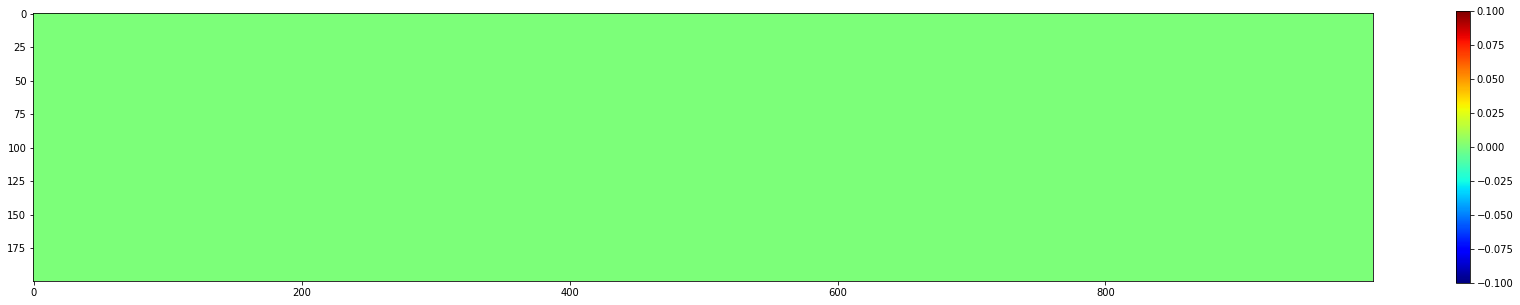

In [ ]:
B_treat = learn_B(c_treat,c_control,num_iterations =10000)